![](img/571_banner.png)

# Lecture 7: Naive Bayes

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar


## Imports

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath("."), "code"))

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from plotting_functions import *

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

%matplotlib inline
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from utils import *

pd.set_option("display.max_colwidth", 200)

## Lecture learning objectives

From this lecture, you will be able to 

- Explain the naive assumption of naive Bayes. 
- Predict targets by hand on toy examples using naive Bayes.
- Use `scikit-learn`'s `MultiNomialNB`, `BernoulliNB`, and `GaussianNB`. 
- Use `predict_proba` for different classifiers and explain its usefulness. 
- Explain the need of smoothing in naive Bayes.
- Explain how `alpha` controls the fundamental tradeoff. 
- Use naive Bayes for multi-class classification. 
- Name advantages and disadvantages of naive Bayes. 

<br><br>

## Motivating example

### Example: spam/ham
Last week in your lab you worked on spam classification using `SVC` classifier. 

$X = \begin{bmatrix}\text{"URGENT!! You have been selected to receive a £900 prize reward!",}\\ \text{"Lol your always so convincing."}\\ \text{"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now!"}\\ \end{bmatrix}$ and $y = \begin{bmatrix}\text{spam} \\ \text{ham} \\ \text{spam} \end{bmatrix}$


ML algorithms we have seen so far prefer fixed length numeric input that looks like this: 

$X = \begin{bmatrix}1.0 & 4.0 & \ldots & & 3.0\\ 0.0 & 2.0 & \ldots & & 6.0\\ 1.0 & 0.0 & \ldots & & 0.0\\ \end{bmatrix}$ and $y = \begin{bmatrix}\text{spam} \\ \text{ham} \\ \text{spam} \end{bmatrix}$


#### `CountVectorizer` to get bag-of-words (BOW) representation

- So we used `CountVectorizer` to convert text data into feature vectors where
    - each feature is a unique word in the text  
    - each feature value represents the frequency or presence/absence of the word in the given message         
<!-- <center>    
<img src='./img/bag-of-words.png' width="800">
</center>        
 -->

![](img/bag-of-words.png)
[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

<br><br><br><br>

## ❓❓ Questions for you

We've focused on "hard" predictions thus far. Can Decision Trees and KNNs provide scores quantifying the certainty of the model or probabilities? If so, how? Discuss the following two scenarios with your neighbour. 

### Exercise 7.1.1 Decision trees: Quantifying the level of certainty of predictions

Imagine you have trained a decision tree and are provided with several new examples for prediction. How would you determine the model's level of certainty at each leaf node?

![](img/spam_toy_decision_tree.png)

<br><br>

### Exercise 7.1.1 KNNs: Quantifying the level of certainty of predictions

Below are five closest neighbors and their targets extracted from [the SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) for a given `test_message`

How would you determine the model's prediction and its level of certainty?

In [2]:
test_message = "Good. No cellphones allowed :)"
s1 = ["Thinkin about someone is all good. No drugs for that", 
      "For sale - arsenal dartboard. Good condition but no doubles or trebles!", 
      "K:)k:)good:)study well.", 
      "No management puzzeles.", 
      "have a good weekend."
     ]
s2 = ["ham", "spam", "ham", "ham", "ham"]

print("Five closest neighbours of the message: ", test_message)
df = pd.DataFrame({"Nearest neighbour": s1, "target": s2})
df

Five closest neighbours of the message:  Good. No cellphones allowed :)


,Nearest neighbour,target
0,Thinkin about someone is all good. No drugs for that,ham
1,For sale - arsenal dartboard. Good condition but no doubles or trebles!,spam
2,K:)k:)good:)study well.,ham
3,No management puzzeles.,ham
4,have a good weekend.,ham


<br><br><br><br>

### Exercise 7.1.3 Calculating $P(spam \mid message)$ and $P(ham \mid message)$

These are reasonable approaches to quantify the level of certainty of models. But how about directly calculating actual probabilities $P(spam \mid message)$ and $P(ham \mid message)$ from the training data? What are the challenges associated with directly calculating these probabilities?

Let's consider a simple example to provide a clearer understanding.

In [3]:
X_toy = [
    "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
    "Lol you are always so convincing. I'm going to give you a free advice. It's urgent.",
    "Block 2 has interesting courses.",
    "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
    "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!",
    "Block 2 has been great so far.",
]
y_toy = ["spam", "ham", "ham", "spam", "spam", "ham"]

toy_df = pd.DataFrame({"sms":X_toy, "target":y_toy})
toy_df

,sms,target
0,URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,spam
1,Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,ham
2,Block 2 has interesting courses.,ham
3,URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,spam
4,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,spam
5,Block 2 has been great so far.,ham


Given this training data and a new unseen message "I'm happy to offer some free advice.", how would you calculate the following probabilities?
- $P(spam \mid \text{I'm happy to offer some free advice})$
- $P(ham \mid \text{I'm happy to offer some free advice})$

How about using the Bayes rule to calculate these probabilities? 

$$P(A \mid B) = \frac{P(B \mid A) \times P(A)}{P(B)}$$

$$P(\text{spam} \mid \text{message})= \frac{P(message \mid spam) \times P(spam)}{P(message)}$$

<br><br>

$$P(\text{ham} \mid \text{message})= \frac{P(message \mid ham) \times P(ham)}{P(message)}$$

Does it make it easier? In this case, we need the following probabilities. 
- $P(\text{spam})$ and $P(\text{ham})$
- $P(\text{message})$
- $P(\text{message} \mid \text{spam})$ and $P(\text{message} \mid \text{ham})$

#### The prior probabilities $P(\text{spam})$ and $P(\text{ham})$
- marginal probability that a message is spam
- marginal probability that a message is ham

![](img/prior_prob.png)
<!-- <img src='./img/prior_prob1.png' width="500"> -->

#### $P(\text{message})$
- marginal probability of a message
    - Hard to calculate but can be ignored in our scenario as it occurs in the denominator for both $P(\text{spam} \mid \text{message})$ and $P(\text{ham} \mid \text{message})$.
    - Since our goal is to get good predictions, and we don't specifically care about the actual probability values, we could ignore the denominator in both cases.
 
![](img/prob_message.png)
<!-- <img src='./img/prob_message.png' width="500"> -->

#### $P(\text{message} \mid \text{spam})$
- The conditional probability $P(\text{message}\mid\text{spam})$ is hard to calculate because it requires a huge number of parameters and impossibly large training sets. 
- In our toy example:
    - $P(\text{message}\mid\text{spam}) = $$P(\text{I} \mid spam) \times P(\text{am} \mid spam, \text{I}) \times \dots \times P(\text{advice} \mid spam, \text{I am happy to offer some free})$

    - $P(\text{message}\mid\text{ham}) = $$P(\text{I} \mid ham) \times P(\text{am} \mid ham, \text{I}) \times \dots \times P(\text{advice} \mid ham, \text{I am happy to offer some free})$
  
- with large number of features, it would require huge numbers of parameters and impossibly large training sets. 
- For example, imagine how hard it would be to estimate probability of the 5,000th word, given the previous 4,999 words.

...But we need this probability. So we start making assumptions. 

**Naive Bayes**, the topic of this lecture makes two simplifying assumptions:

**Bag-of-words representation** 

Information about the order and structure of words in the text is lost, but the frequency or presence of each word is retained.

**Conditional independence assumption**

This is the "naive" part of naive Bayes. Given the target (like spam or not-spam), the presence (or absence) of each word is assumed to be **conditionally independent** of the presence (or absence) of any other word. This assumption simplifies the computation and makes the method tractable for high-dimensional data, even though it's a strong and often unrealistic assumption.

$$P(\text{I am happy to offer some free advice}\mid\text{spam}) \approx P(\text{I} \mid spam) \times P(\text{am} \mid spam) \times P(\text{happy} \mid spam) \times \dots \times P(\text{advice} \mid spam)$$

<br><br><br><br>

## Naive Bayes

- Our first probabilistic classifier where we think of learning as a problem of statistical inference.
- In late 1990's a graduate student from Stanford, Mehran Sahami, did an internship at Microsoft Research, where he collaborated with others on the use of Naive Bayes for spam filtering. The work was pioneering at that time. 
    - Check out [the original paper](http://robotics.stanford.edu/users/sahami/papers-dir/spam.pdf)
- For years, best spam filtering methods used naive Bayes.
- For example, [SpamAssassin](https://spamassassin.apache.org/) is a spam filtering system based on naive Bayes. 
- Even today naive Bayes forms a basis for many disease diagnosis and spam filtering systems.
- At some point it was one of the most widely used learner at Google.  

### SVC classifier for spam detection 

- Before discussing how it works, let's try it out with sklearn. 
- Let's first try SVC classifier on [the SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset). (This is what you did in the lab last week.)

In [4]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [5]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


In [6]:
results_dict = {}
pipe_svc = make_pipeline(CountVectorizer(), SVC())
results_dict["SVC"] = mean_std_cross_val_scores(
    pipe_svc, X_train, y_train, return_train_score=True
)

/Users/kvarada/MDS/2023-24/571/DSCI_571_sup-learn-1_students/lectures/code/utils.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [7]:
pd.DataFrame(results_dict)

,SVC
fit_time,0.483 (+/- 0.017)
score_time,0.113 (+/- 0.006)
test_score,0.978 (+/- 0.005)
train_score,0.995 (+/- 0.001)


### `sklearn` naive Bayes classifier 

- Let's try Naive Bayes on this problem. 

In [8]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
results_dict["Naive Bayes"] = mean_std_cross_val_scores(
    pipe_nb, X_train, y_train, return_train_score=True
)

/Users/kvarada/MDS/2023-24/571/DSCI_571_sup-learn-1_students/lectures/code/utils.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [9]:
pd.DataFrame(results_dict)

,SVC,Naive Bayes
fit_time,0.483 (+/- 0.017),0.041 (+/- 0.001)
score_time,0.113 (+/- 0.006),0.009 (+/- 0.000)
test_score,0.978 (+/- 0.005),0.986 (+/- 0.003)
train_score,0.995 (+/- 0.001),0.993 (+/- 0.001)


- The validation scores are a bit better on this particular dataset.
- Much faster than the SVC classifier!! 

Now let's try to understand how `predict` and `fit` work for this model. Let's bring back the toy dataset from before and encode it with BOW representation.  

In [10]:
X_toy = [
    "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
    "Lol you are always so convincing. I'm going to give you a free advice. It's urgent.",
    "Block 2 has interesting courses.",
    "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
    "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!",
    "Block 2 has been great so far.",
]
y_toy = ["spam", "ham", "ham", "spam", "spam", "ham"]
toy_df = pd.DataFrame({"sms":X_toy, "target":y_toy})

- For simplicity, let's use `CountVectorizer` with `binary=True`, i.e., assume presence or absence of words instead of counts and only consider the top 4 features.    

In [11]:
vec = CountVectorizer(max_features=4, stop_words="english", binary=True)
X_toy_vec = vec.fit_transform(X_toy, y_toy)

In [12]:
toy_bow_df = pd.DataFrame(
    X_toy_vec.toarray(), columns=vec.get_feature_names_out(), index=X_toy
)
toy_bow_df["target"] = y_toy
toy_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,0,1,0,1,ham
Block 2 has interesting courses.,1,0,0,0,ham
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been great so far.,1,0,0,0,ham


### Naive Bayes `predict`

- Given new messages, we want to predict whether they are spam or ham.
- Example: Predict whether the following message is spam or ham. 
> "URGENT! Free!!"

Remember the two simplifying assumptions of naive Bayes? 

**BOW representaion**: First, let's get BOW representation of the message.  

In [13]:
deploy_test = ["URGENT! Free!!", "Let's enjoy the last week of block 2!"]
deploy_bow = vec.transform(deploy_test).toarray()
bow_df = pd.DataFrame(
    deploy_bow, columns=vec.get_feature_names_out(), index=deploy_test
)
bow_df

,block,free,prize,urgent
URGENT! Free!!,0,1,0,1
Let's enjoy the last week of block 2!,1,0,0,0


Let's try predicting with `pipe_nb`. 

In [14]:
pipe_nb.fit(X_train, y_train)

pipe_nb.predict(deploy_test)

array(['spam', 'ham'], dtype='<U4')

What's happening under the hood? To predict the correct class, assuming **conditional independence**, naive Bayes estimates some scores which are proportional to the following probabilities and picks the target with higher score.

- $P(\text{spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1}) \propto  P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1} \mid \text{spam}) \times P(spam)$ 
- $P(\text{ham} \mid  \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1}) \propto  P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1} \mid \text{spam}) \times P(ham)$

For each target, we need to calculate two probabilities: 
- **Prior probabilities**: $P(\text{target})$
- **Conditional probabilities**: $P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1} \mid \text{target})$

#### Computing prior probabilities 
- Prior probability: what's the proportion of the target class occurs in our training dataset?
    - $P(\text{spam}) = 3/6$    
    - $P(\text{ham}) = 3/6$

In [15]:
toy_bow_df['target'].value_counts()

target
spam    3
ham     3
Name: count, dtype: int64

#### Computing conditional probabilities 

- Assumption: **Features are independent, conditioned on the target**. 
    - Example: In our spam classification example, **once you know that a message is spam**, the probability that the word "urgent" appears is independent of whether "free" also appeared. 
    - So if you know that a message is spam, knowing whether the word "urgent" occurs gives no additional information about whether "free" also appears. 
    
- We can write this mathematically as 

$$\begin{equation}
\begin{split}
& P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \\
&\approx P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam})\\\\
& P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{ham}) \\
&\approx P(\text{block} = 0 \mid \text{ham}) \times P(\text{free} = 1 \mid \text{ham}) \times P(\text{prize} = 0 \mid \text{ham}) \times P(\text{urgent} = 1 \mid \text{ham})
\end{split}
\end{equation}$$


We can calculate these based on the frequencies of these words in our training data. 

In [16]:
spam_toy_df = toy_df[toy_df['target'] == 'spam']
ham_toy_df = toy_df[toy_df['target'] == 'ham']

/Users/kvarada/MDS/2023-24/571/DSCI_571_sup-learn-1_students/lectures/code/plotting_functions.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=spam_words, rotation=45)
/Users/kvarada/MDS/2023-24/571/DSCI_571_sup-learn-1_students/lectures/code/plotting_functions.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels=ham_words, rotation=45)


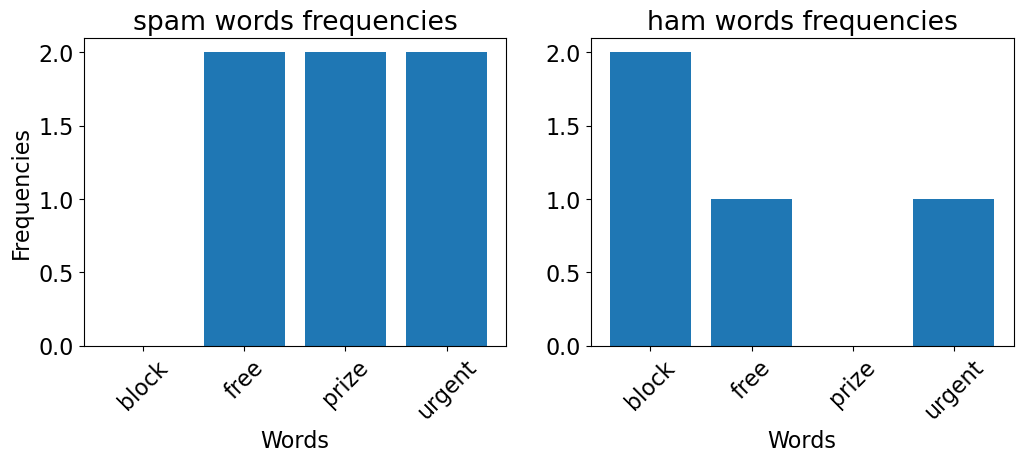

In [17]:
plot_spam_ham_word_freq(spam_toy_df['sms'], ham_toy_df['sms']) # custom function defined in code/plotting_functions.oy

So in this toy example, for each target, we need the following conditional probabilities for prediction.
1. $P(\text{block} = 0 \mid \text{target})$
2. $P(\text{free} = 1 \mid \text{target})$
3. $P(\text{prize} = 0 \mid \text{target})$
4. $P(\text{urgent} = 1 \mid \text{target})$
use our training data to estimate these probabilities. 

In [18]:
toy_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,0,1,0,1,ham
Block 2 has interesting courses.,1,0,0,0,ham
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been great so far.,1,0,0,0,ham


#### Conditional probabilities for the target spam
- What is $P(\text{block} = 0 \mid \text{spam})$? 
    - Given target is spam, how often "block" = 0? $3/3$
- $P(\text{free} = 1 \mid \text{spam}) = 2/3$ 
- $P(\text{prize} = 0 \mid \text{spam}) = 1/3$
- $P(\text{urgent} = 1 \mid \text{spam}) = 2/3$


So using naive Bayes, $P(\text{spam} \mid \text{message})$ is proportional to 

$$\begin{equation}
\begin{split}
P(\text{spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \\
& \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto 3/3 \times 2/3 \times 1/3 \times 2/3 \times 3/6\\
\end{split}
\end{equation}$$


In [19]:
spam_prior = 3 / 6
block0_spam = 3 / 3
free1_spam = 2 / 3
prize0_spam = 1 / 3
urgent1_spam = 2 / 3
spam_estimate = spam_prior * block0_spam * free1_spam * prize0_spam * urgent1_spam
spam_estimate

0.07407407407407407

#### Conditional probabilities for the target ham 

- What is $P(\text{block} = 0 \mid \text{ham})$? 
    - Given target is ham, how often "block" = 0? $1/3$
- $P(\text{free} = 1 \mid \text{ham}) = 1/3$ 
- $P(\text{prize} = 0 \mid \text{ham}) = 3/3$
- $P(\text{urgent} = 1 \mid \text{ham}) = 1/3$

So using naive Bayes, $P(\text{ham} \mid \text{message})$ is proportional to 
$$\begin{equation}
\begin{split}
P(\text{ham} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{ham}) \times P(\text{ham})\\
&\propto P(\text{block} = 0 \mid \text{ham}) \times P(\text{free} = 1 \mid \text{ham}) \\
& \times P(\text{prize} = 0 \mid \text{ham}) \times P(\text{urgent} = 1 \mid \text{ham}) \times P(\text{ham})\\
&\propto 1/3 \times 1/3 \times 3/3 \times 1/3 \times 3/6\\
\end{split}
\end{equation}$$


In [20]:
ham_prior = 3 / 6
block0_ham = 1 / 3
free1_ham = 1 / 3
prize0_ham = 3 / 3
urgent1_ham = 1 / 3
ham_estimate = (
    ham_prior
    * block0_ham
    * free1_ham
    * prize0_ham
    * urgent1_ham
)
ham_estimate

0.018518518518518517

In [21]:
print('spam estimate: ', spam_estimate)
print('ham estimate: ', ham_estimate)

spam estimate:  0.07407407407407407
ham estimate:  0.018518518518518517


Since $P(spam \mid message)$ is proportional to a bigger number, we pick "spam" as the label.

- Note that these estimates are not well-defined probabilities, as we ignored the denominator when calculating these estimates. 
- Let's normalize these estimates so that they sum to 1.0 

In [22]:
normalizer = spam_estimate + ham_estimate
spam_prob_score = spam_estimate / normalizer
ham_prob_score = ham_estimate / normalizer
[ham_prob_score, spam_prob_score]

[0.2, 0.8]

Let's examine whether we get the same numbers with `sklearn`'s `BernoulliNB`. 
- We are using `BernoulliNB` because our features are binary. 

In [23]:
nb = BernoulliNB(alpha=0)
nb.fit(X_toy_vec, y_toy)

/Users/kvarada/miniconda3/envs/571/lib/python3.10/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/kvarada/miniconda3/envs/571/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


BernoulliNB(alpha=0)

- We can use `predict_proba` method to get the estimated probability scores. 
- More on `predict_proba` in the next class. 

In [24]:
nb.predict_proba(deploy_bow)[0]

array([0.2, 0.8])

In [25]:
nb.classes_

array(['ham', 'spam'], dtype='<U4')

They match with what we calculated by hand 🎉🎉!! 

<br><br>

### Summary of naive Bayes `predict`
- Use Bayes rule to calculate the conditional probability of each target given the message. 

$$ P(\text{target} \mid \text{message}) = \frac{P(\text{message} \mid \text{target}) \times P(\text{target})}{P(\text{message})} $$

- $P(\text{message})$: marginal probability that a message has the given set of words 
    - Hard to calculate but can be ignored in our scenario.


$$ P(\text{target} \mid \text{message}) \propto P(\text{message} \mid\text{target}) \times P(\text{target}) =  P(w_1, w_2, \dots, w_d \mid \text{target}) \times P(\text{target})$$

- We need the following terms:  
    - $P(\text{target})$: marginal probability that a message has the class target
    - $P(\text{message}\mid\text{target})$: conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is of the given target.
        - Hard to calculate but we need it. We would require huge numbers of parameters and impossibly large training sets. 
        - Naive assumption that features are independent of each other conditioned on the target. 

        $$P(\text{message} \mid \text{target}) = P(w_1, w_2, . . . , w_d \mid \text{target}) \approx \prod_{i=1}^{d}P(w_i \mid \text{target})$$


### Summary naive Bayes `predict`

Using naive Bayes assumption, estimate scores that are proportional to the following probabilities. 

$$ P(\text{target} \mid \text{message}) \propto P(\text{target}) \times  \prod_{i=1}^{d}P(w_i \mid \text{target})$$

- Predict the target where $P(\text{target} \mid \text{message})$ is proportional to a bigger value. 

### ❓❓ Questions for you

- When we ignore the marginal probability P(message) when calculating $P(\text{spam} | \text{message})$ or $P(\text{ham} | \text{message})$, are these going to be well-defined probabilites? Does it matter?
- When calculating conditional probabilities, why do we consider both present and absent words?  

## ❓❓ Questions for you

### (iClicker) Exercise 7.2

**iClicker cloud join link: https://join.iclicker.com/DAZZ**

**Select all of the following statements which are TRUE.**

- (A) In Bernoulli naive Bayes, for binary classification, we need to calculate $2d+1$ probabilities, where $d$ is the number of unique words. 
- (B) Naive Bayes should only be used if the "naive" conditional independence assumption holds for your problem.
- (C) Naive Bayes should only be used when the features (i.e. `X`-values) are binary.`

```{admonition} V's Solutions!
:class: tip, dropdown
- A
```

## Break (5 min)

![](img/eva-coffee.png)


### Naive Bayes classifier `fit`

- Counting and estimating probabilities. 
- Estimate prior probabilities and conditional probabilities for each feature given each class. 

### Prior probabilities

- P(target) $\rightarrow$ how often target $c$ occurs in our dataset in comparison with all other targets.

$$P(c) = \frac{N_c}{N}$$

where, 
- $N_c$ is the number of examples with target $c$ 
- $N$ is total number of examples

### Conditional probabilities 

- Above, we only calculated conditional probabilities which were required for estimating probability score for class given given message. 
- Naive Bayes calculates all conditional probabilities for each feature given each class in advance during `fit`. 
- Then during `predict` it just multiplies the appropriate probabilities. 

In case of Bernoulli naive Bayes with binary classification, for each feature $w$ and target $c$, it calculates four probabilities: 
- $P(w = 1 \mid c = 0) \rightarrow$ Probability that the word is present given target 0.
- $P(w = 0 \mid c = 0) \rightarrow$ Probability that the word is absent given target 0.
- $P(w = 1 \mid c = 1) \rightarrow$ Probability that the word is present given target 1.
- $P(w = 0 \mid c = 1) \rightarrow$ Probability that the word is absent given target 1.

But $P(w = 0 \mid c = 0) = 1 - P(w = 1 \mid c = 0)$
And $P(w = 0 \mid c = 1) = 1 - P(w = 1 \mid c = 1)$

So in reality we just need to calculate two probabilities for each word. 

We calculate these probabilities by counting word and target occurrences in the training data. For example, 
$$ P(w = 1\mid c = 1) = \frac{Count(w = 1, c = 1)}{Count(c = 1)}$$ 

- This is called _maximum likelihood estimation_. 
- It stores these probabilities, which will be later used during predict time.   

<br><br><br><br>

## Laplace smoothing

In [26]:
toy_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,0,1,0,1,ham
Block 2 has interesting courses.,1,0,0,0,ham
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been great so far.,1,0,0,0,ham


What will happen if you want to predict for: 

In [27]:
test_ex = ["urgent free block"]

In [28]:
transformed = vec.transform(test_ex)
transformed.toarray()

array([[1, 1, 0, 1]])

In [29]:
spam_prior = 3 / 6
block1_spam = 0 / 3
free1_spam = 2 / 3
prize0_spam = 1 / 3
urgent1_spam = 2 / 3

In [30]:
spam_prior * block1_spam * free1_spam * prize0_spam * urgent1_spam

0.0

- Although all the other words are yelling SPAM! SPAM! SPAM!, since we do not have any example where the word "block" occurs with spam, we get a zero probability. 

![](img/eva-qm.png)

- Naive Bayes naively multiplies all the feature likelihoods together, and if any of the terms is zero, it's going to void all other evidence and the probability of the class is going to be zero. 
- Sounds worrisome! 
- We have limited data and if we do not see a feature occurring with a class, it doesn't mean it would never occur with that class. 
- How can we tackle this and avoid obliterating all other probabilities because of one zero in the product?  

### A simplest solution: Laplace smoothing
- The simplest way to avoid zero probabilities is to add one to the counts when we calculate conditional probabilities.
- For example, a smoothed probability of  
    $$ P(\text{block} = 1 \mid \text{spam}) = = \frac{\text{\# documents where block occurs with spam} + 1 }{\text{how often spam occurs} + \text{\# number of possible word values}}$$

$$ P(\text{block} = 1 \mid \text{spam}) = \frac{0 + 1}{3+2}$$


In [31]:
spam_prior = 3 / 6
block1_spam_sm = (0 + 1) / (3 + 2)
free1_spam_sm = (2 + 1) / (3 + 2)
prize0_spam_sm = (1 + 1) / (3 + 2)
urgent1_spam_sm = (2 + 1) / (3 + 2)

In [32]:
spam_prior * block1_spam_sm * free1_spam_sm * prize0_spam_sm * urgent1_spam_sm

0.0144

- All the counts that used to be zero will now have a count of 1

- Even though our encoding contains only 0's and 1's, we can try different values for smoothing.
- In `scikit-learn` we control it using hyperparameter `alpha` (by default `alpha=1.0`). 
- Check out sklearn's documentation on [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)

Let's try this out on the example above. 

In [33]:
test_ex

['urgent free block']

In [34]:
transformed.toarray()

array([[1, 1, 0, 1]])

In [35]:
# We are now getting more sensible probabilities.   
nb_sm = BernoulliNB(alpha=1.0)
nb_sm.fit(X_toy_vec, y_toy)
nb_sm.predict_proba(transformed)

array([[0.72727273, 0.27272727]])

In [36]:
nb_sm.classes_

array(['ham', 'spam'], dtype='<U4')

### `alpha` hyperparameter and the fundamental tradeoff 

- High alpha $\rightarrow$ underfitting
    - means we are adding large counts to everything and so we are diluting the data
- Low alpha $\rightarrow$ overfitting

In [37]:
results_dict = {
    "alpha": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"bernoullinb__alpha": 10.0 ** np.arange(-7, 3)}

pipe_nb = make_pipeline(CountVectorizer(), BernoulliNB())
search = GridSearchCV(pipe_nb, param_grid, n_jobs=-1, return_train_score=True)
search.fit(X_train, y_train);

In [38]:
test_scores = search.cv_results_["mean_test_score"]
train_scores = search.cv_results_["mean_train_score"]
alpha_vals = param_grid["bernoullinb__alpha"]

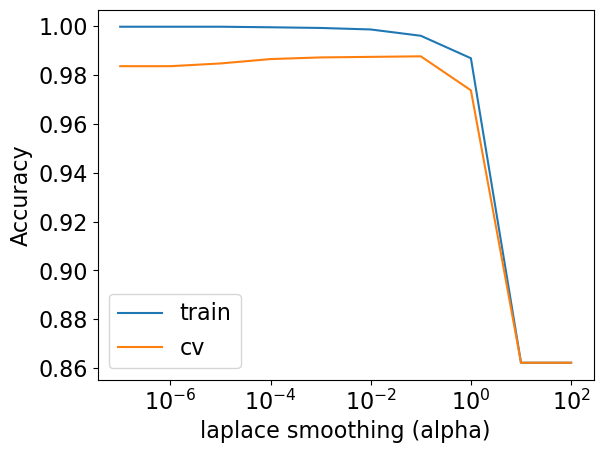

In [39]:
plt.semilogx(alpha_vals, train_scores, label="train")
plt.semilogx(alpha_vals, test_scores, label="cv")
plt.legend()
plt.xlabel("laplace smoothing (alpha)")
plt.ylabel("Accuracy");

### (Optional) Details on the formulas

- In case of `MultinomialNB`, the conditional probabilities will change with the following formula.  

$$ P(w \mid c) = \frac{Count(w, c) + 1 }{Count(c) + \mid vocabulary \mid}$$ 

- In case of Bernoulli naive Bayes, when you calculate conditional probabilities with Laplace smoothing, the formula is slightly different: 

$$ P(w \mid c) = \frac{Count(w, c) + 1 }{Count(c) + 2 }$$ 

- So instead of the $\mid vocabulary \mid$ we just add 2. See the sklearn code [here](https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/naive_bayes.py#L1031) and [this Stack overflow post](https://stackoverflow.com/questions/40448784/laplace-smoothing-for-bernoulli-model-for-naive-bayes-classifier) for explanation.

Note that when we estimated probabilities in our toy example (e.g., $P(\text{word} \mid spam)$), we happened to have each feature value as either 0 or 1, i.e., just the existence of a word in the document's bag of words. We computed $P(\text{word} \mid spam)$ as a fraction of times the word appears among all words in all messages of the spam class. If we want to work with frequencies instead of existence, we first concatenate all documents with that class (e.g., spam class) into one big "class c" text. Then we use the frequency of the word (e.g., _urgent_ below) in this concatenated document to give a (maximum likelihood) estimate of the probability:

$$P(\text{urgent} \mid \text{spam}) = \frac{Count(\text{urgent}, \text{spam})}{\sum_{w \in vocabulary} Count(w, \text{spam})}$$ 

$$P(\text{urgent} \mid \text{spam}) = \frac{\text{how often urgent occurs with spam}}{\text{total number of tokens (all occurrences of all words) in spam}}$$

<br><br><br><br>

## Naive Bayes with continuous features

- We can use Gaussian Naive Bayes if you have continuous features. ([Watch this](https://www.youtube.com/watch?v=H3EjCKtlVog)).
- Here is the general idea of Gaussian naive Bayes:
    - Assume each feature is normally distributed. 
    - Calculate the mean ($\mu_k$) and standard deviation ($\sigma_k$) for each feature for each class.
    - Use the following equation to calculate the likelihood of observing feature value $v$ in class $C_k$

![](img/gaus_nb.png)

<!-- <center>
<img src='./img/gaus_nb.png' width="400">
</center>
 -->
Source: [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes)

Let's work through a toy example. 

In [40]:
import pandas as pd

data = {
    'Weight (in grams)': [100, 105, 103, 101, 160, 162, 163, 164],
    'Sugar Content (in %)': [10, 11, 10.5, 10.2, 18, 19, 19.5, 18.8],
    'Fruit': ['Apple', 'Apple', 'Apple', 'Apple', 'Orange', 'Orange', 'Orange', 'Orange']
}

df = pd.DataFrame(data)

df

,Weight (in grams),Sugar Content (in %),Fruit
0,100,10.0,Apple
1,105,11.0,Apple
2,103,10.5,Apple
3,101,10.2,Apple
4,160,18.0,Orange
5,162,19.0,Orange
6,163,19.5,Orange
7,164,18.8,Orange


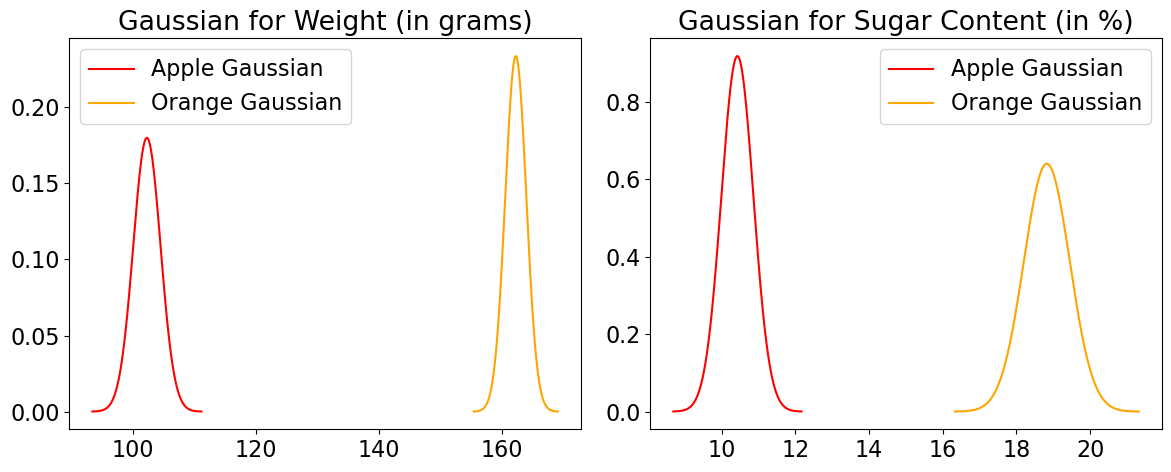

In [41]:
plot_gaussians(df) # custom-defined function in code/plotting_functions.py

In [42]:
df.describe()

,Weight (in grams),Sugar Content (in %)
count,8.000000,8.000000
mean,132.250000,14.625000
std,32.123645,4.517506
min,100.000000,10.000000
25%,102.500000,10.425000
50%,132.500000,14.500000
75%,162.250000,18.850000
max,164.000000,19.500000


In [43]:
X_toy = df.drop(columns = ['Fruit'])
y_toy = df['Fruit']

Let's say we have a test fruit with a weight of 106 grams and a sugar content of 11% and we want to predict the class. 
We'll compute the likelihood of these values for both fruits using the Gaussian pdf:

In [44]:
def gaussian_pdf(x, mean, variance):
    return (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-np.power(x - mean, 2) / (2 * variance))

# Compute conditional probabilities for the given observation
observed_weight = 106
observed_sugar_content = 11

likelihoods = {}
for fruit in ['Apple', 'Orange']:
    likelihoods[fruit] = {}
    for feature, observed_value in [('Weight (in grams)', observed_weight), ('Sugar Content (in %)', observed_sugar_content)]:
        mean = df[df['Fruit'] == fruit][feature].mean()
        variance = df[df['Fruit'] == fruit][feature].var()
        likelihoods[fruit][feature + "=" + str(observed_value)] = gaussian_pdf(observed_value, mean, variance)
        

In [45]:
pd.DataFrame(likelihoods)

,Apple,Orange
Weight (in grams)=106,0.043052,6.345802e-237
Sugar Content (in %)=11,0.382788,4.368922e-35


$p(Apple \mid  \text{Weight (in grams) = 106, Sugar Content (in \%) = 11}) = $ 
$ p(Apple) \times p(\text{Weight (in grams} = 106 \mid c = \text{Apple})  \times  p(\text{Sugar Content (in \%)} = 11 \mid c = \text{Apple})$

$p(Orange \mid  \text{Weight (in grams) = 106, Sugar Content (in \%) = 11}) = $ 
$ p(Orange) \times p(\text{Weight (in grams} = 106 \mid c = \text{Orange})  \times  p(\text{Sugar Content (in \%)} = 11 \mid c = \text{Orange})$

In [46]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_toy.values, y_toy)

GaussianNB()

In [47]:
model.var_, model.theta_

(array([[3.6875009, 0.1418759],
        [2.1875009, 0.2918759]]),
 array([[102.25 ,  10.425],
        [162.25 ,  18.825]]))

In [48]:
model.class_prior_

array([0.5, 0.5])

In [49]:
model.predict([[106.0, 11.0]])

array(['Apple'], dtype='<U6')

- Gaussian naive Bayes assumes normality
    - If the features are not normally distributed transform the data to make them more normal
    - Scikit-learn provides the `PowerTransformer()` for this process
    - From the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer): "*...Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like.*"

<br><br><br><br>

### (Optional) The generative model behind naive Bayes

- Naive Bayes is a **generative model** because it's modeling the joint distribution over the features $X$ and labels $y$.
- In the next lecture, we'll look at a **discriminative model**, which models $P(y\mid X)$ rather than $P(X,y)$.
- Right now just get familiar with these terms. We'll talk more about them later in the program. 

It's weird to think of the features as random, but we're saying they come from those Gaussians above.

In [50]:
model.class_prior_

array([0.5, 0.5])

In [51]:
model.var_

array([[3.6875009, 0.1418759],
       [2.1875009, 0.2918759]])

In [52]:
model.theta_

array([[102.25 ,  10.425],
       [162.25 ,  18.825]])

In [53]:
def gen_gaussian_nb(means, sigmas, p_y, n=500):
    # means:  a 2D array of size num_classes by num features containing the means of the Gaussians
    # sigmas: a 2D array of size num_classes by num features containing the standard deviations of the Gaussians
    # p_y   : a 1D array of length num_classes containing the probability of each class
    # n     : an integer for the number of samples ("size of sample") to generate

    C = 2 # number of classes
    d = 2 # number of features
    X_generated = np.zeros((n,d))
    y_generated = np.zeros((n))
    for i in range(n):
        # pick Canadian city/USA city
        k = np.random.choice(C, p=p_y)
        for j in range(d):
            X_generated[i,j] = means[k,j] + sigmas[k,j] * np.random.randn()
        y_generated[i] = k    
        
    return X_generated, y_generated

In [54]:
X_generated, y_generated = gen_gaussian_nb(model.theta_, np.sqrt(model.var_), model.class_prior_)

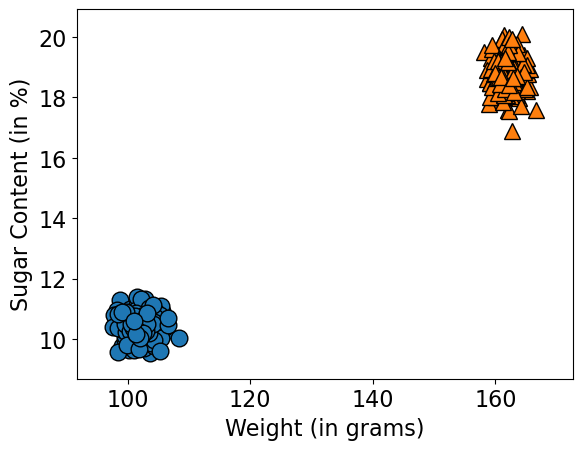

In [55]:
mglearn.discrete_scatter(X_generated[:, 0], X_generated[:, 1], y_generated, s=12)
plt.xlabel("Weight (in grams)")
plt.ylabel("Sugar Content (in %)");

We can experiment with different priors. 

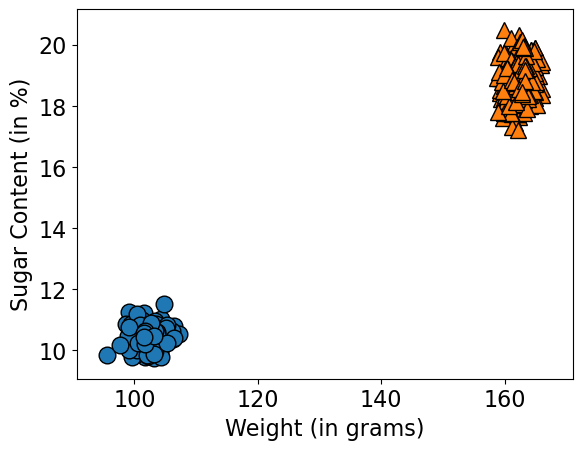

In [56]:
X_generated, y_generated = gen_gaussian_nb(model.theta_, np.sqrt(model.var_), [0.2,0.8])
mglearn.discrete_scatter(X_generated[:, 0], X_generated[:, 1], y_generated, s=12)
plt.xlabel("Weight (in grams)")
plt.ylabel("Sugar Content (in %)");

<br><br><br><br>

## (Optional) Naive Bayes on multi-class problems 

Let's use `sklearn`'s inbuilt 20 newsgroups dataset. It comprises around 18,000 newsgroups posts on 20 topics. So it's a 20-class classification problem. 

In [57]:
from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)
newsgroups_test = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes")
)
X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
X_news_test, y_news_test = newsgroups_test.data, newsgroups_test.target

Here are the 20 topics (targets or classes) in the dataset. 

In [58]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Let's try `DummyClassifier`

In [59]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_news_train, y_news_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002476,0.001425,0.053027,0.053033
1,0.001438,0.000262,0.053027,0.053033
2,0.001139,0.000248,0.053027,0.053033
3,0.001165,0.000242,0.053027,0.053033
4,0.001144,0.000234,0.053050,0.053027


The scores are very low because we have 20 different classes!! 

### Let's try `MultinomialNB`

In [60]:
pipe_multi = make_pipeline(CountVectorizer(), MultinomialNB())
scores = cross_validate(pipe_multi, X_news_train, y_news_train, return_train_score=True)

In [61]:
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.935332,0.188610,0.583738,0.741465
1,0.809867,0.199714,0.570040,0.739587
2,0.820616,0.182462,0.583297,0.749309
3,0.845887,0.173523,0.571365,0.731963
4,0.814050,0.173680,0.588859,0.739063


The validation scores are low but much better than the `DummyClassifier`.  

Let's try to predict on an example. 

In [62]:
pipe_multi.fit(X_news_train, y_news_train);

In [63]:
print(X_news_test[100])
prediction = pipe_multi.predict([X_news_test[100]])[0]
print(
    "Prediction index: %d and prediction class: %s"
    % (prediction, newsgroups_train.target_names[prediction])
)

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris
Prediction index: 5 and prediction class: comp.windows.x


And here are prediction probabilities. 

In [64]:
pipe_multi.predict_proba([X_news_test[100]])

array([[7.26904475e-19, 1.48743104e-10, 4.16538604e-28, 2.96340768e-10,
        1.91391647e-14, 1.00000000e+00, 4.34194388e-28, 2.40916532e-18,
        9.74009600e-22, 1.72603033e-31, 5.61184330e-31, 8.76853929e-14,
        1.00705690e-16, 2.70331089e-13, 2.36762710e-21, 5.91222397e-16,
        3.61589511e-15, 1.49715839e-13, 2.92789387e-16, 1.20413840e-24]])

<br><br><br><br>

## Summary and final remarks

### General comments on naive Bayes

- Family of probabilistic classifiers 
- GausianNB is used on very high dimensional numeric data
- BernoulliNB and MultinomialNB are used for sparse data (e.g., text data). 
    - MultinomialNB usually performs better than BernoulliNB, especially when you are working with large documents.
    - Complexity hyperparameter: `alpha`

- A fast and robust way to learn the corresponding parameters
- Training procedure is easy to understand 
- Surprising accuracy considering its simplicity
- Scales great; learning a naive Bayes classifier is just a matter of counting how many times each attribute co-occurs with each class
- To avoid underflow, all the calculations are done with log likelihoods.  
- Can be easily used for multi-class classification

- It's closely related to linear classifiers, which we'll see in the next lecture. 
    - When we take the logarithms, the products turn into summations. 
- Can provides a informative set of features from which to predict the class (next class)

- Often provide generalization performance that is slightly worse 
- Assumes that spammers generate e-mails by picking words at random. It means that sentences have no syntax and content. Is that a fair assumption? 
    - oversimplification 
    - sometimes the best theories are the most oversimplified 🤷🏻‍♀️

- Although naive Bayes is known as a decent classifier, it is known to be a **bad estimator**, so the probability outputs from `predict_proba` are not to be taken too seriously.

![](img/eva-seeyou.png)
